In [2]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv('train.csv')
macro = pd.read_csv('macro.csv')

In [4]:
train = pd.merge(train, macro, on='timestamp')
#совмещаем датасеты по дате, чтобы использовать все данные

In [5]:
usd_end = train.at[train.index[-1], 'usdrub']
for ind in train.index:
    train.at[ind, 'price_doc'] *= (usd_end / train.at[ind, 'usdrub'])
#воспользуемся курсом доллара для отсчета ценности рубля, так как в данном промежутке времени он сильно обесценился

C:\Users\37ham\AppData\Local\Temp\ipykernel_13132\966070176.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11146540.40020962' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.at[ind, 'price_doc'] *= (usd_end / train.at[ind, 'usdrub'])


In [6]:
train.to_csv('comb.csv')

In [7]:
train = train.replace("no", 0)
train = train.replace("yes", 1)
train = train.replace("Investment", 0)
train = train.replace("OwnerOccupier", 1)
train = train.replace("poor", 1)
train = train.replace("satisfactory", 2)
train = train.replace("good", 3)
train = train.replace("excellent", 4)
train = train.replace("no data", np.nan)
#заменяем все бинарные данные, а также классификацию экологии, на численный эквивалент

C:\Users\37ham\AppData\Local\Temp\ipykernel_13132\2826560499.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train = train.replace("yes", 1)
C:\Users\37ham\AppData\Local\Temp\ipykernel_13132\2826560499.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train = train.replace("OwnerOccupier", 1)
C:\Users\37ham\AppData\Local\Temp\ipykernel_13132\2826560499.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects

In [8]:
for col in train.columns:
    if not pd.api.types.is_numeric_dtype(train[col]):
        print(col, train[col].dtype)

timestamp object
sub_area object
child_on_acc_pre_school object
modern_education_share object
old_education_build_share object


In [9]:
train = train.drop(['id', 'timestamp', 'sub_area', 'child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share'], axis=1)
#исключаем колонки с мусорными данными, те колонки, которые не должны никак коррелировать с ценой, и названия районов (эти данные в более развернутом виде представлены далее как информация о районе)

In [10]:
train.to_csv('comb.csv')

In [11]:
corr = train.corr()['price_doc']
#предварительно проанализируем корреляцию цены с данными

In [12]:
corr = corr.abs().sort_values()

In [13]:
corr

cafe_sum_3000_min_price_avg          0.000837
cafe_avg_price_3000                  0.001525
cafe_sum_3000_max_price_avg          0.003019
housing_fund_sqm                     0.003859
build_year                           0.004658
                                       ...   
sport_count_5000                     0.282634
full_sq                              0.327277
num_room                             0.453778
price_doc                            1.000000
provision_retail_space_modern_sqm         NaN
Name: price_doc, Length: 385, dtype: float64

In [14]:
corr = corr.drop(['provision_retail_space_modern_sqm'])
train = train.drop(['provision_retail_space_modern_sqm'], axis=1)
#слишком мало данных, не считается корреляция

In [15]:
corr = corr.drop(['price_doc'])

In [16]:
s = train.isna().sum()
s[s != 0]
#смотрим, где не хватает данных

life_sq                           6383
floor                              167
max_floor                         9572
material                          9572
build_year                       13605
                                 ...  
theaters_viewers_per_1000_cap    16901
museum_visitis_per_100_cap       16901
population_reg_sports_share       3239
students_reg_sports_share        16901
apartment_build                   3239
Length: 90, dtype: int64

In [17]:
corr.to_csv('corr_res.csv')

In [18]:
info = pd.DataFrame([corr, s])

In [19]:
for col in info.columns:
    if info[col].iloc[1] == 0.0:
        info.drop(col, axis=1, inplace=True)

In [20]:
info = info.transpose()

In [21]:
info

,price_doc,Unnamed 0
cafe_sum_3000_min_price_avg,0.000837,991.0
cafe_avg_price_3000,0.001525,991.0
cafe_sum_3000_max_price_avg,0.003019,991.0
housing_fund_sqm,0.003859,3239.0
build_year,0.004658,13605.0
...,...,...
hospital_beds_raion,0.156703,14441.0
life_sq,0.157784,6383.0
metro_km_walk,0.185287,25.0
metro_min_walk,0.185287,25.0


In [22]:
info_view = info.copy()
info_view['Unnamed 0'] = info_view['Unnamed 0'].div(50000)

<Axes: >

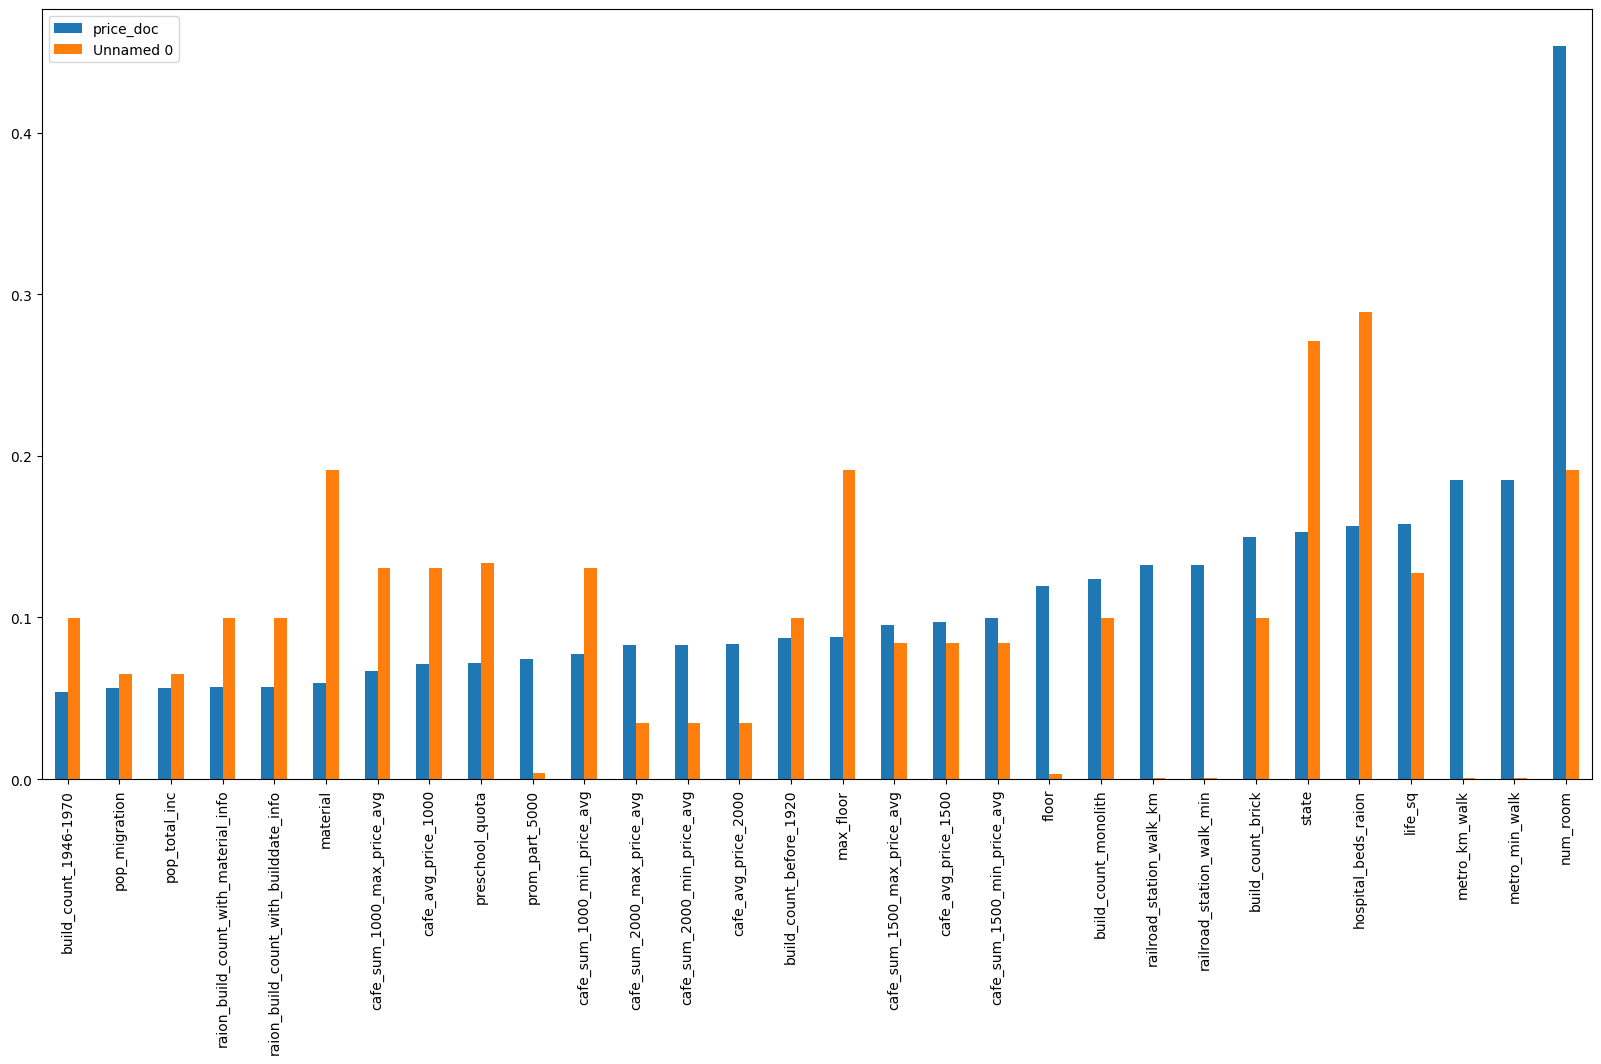

In [23]:
info_view.tail(30).plot.bar(figsize=(20, 10))

In [ ]:
#оцениваем, как исправить ситуацию с пропусками
#если пропусков мало, то просто удаляем строки с этими пропусками
#если пропусков много, а данные не сильно значимые (меньше или около 0.1), то выкидываем колонку
#остается обработать num_room, life_sq, hospital_beds, state, build_count_..., floor
#hospital_beds, build_count_... данные, относящиеся к району, которые мы не можем восстановить, так как по тем районам этой информации просто нет
#оставшиеся данные будем заполнять регрессией

In [24]:
info.to_csv('info_res.csv')

In [25]:
delete = []
info = info.transpose()
for col in info.columns:
    if info[col].iloc[0] < 0.1:
        delete.append(col)
info = info.transpose()

In [26]:
train = train.drop(['build_count_brick','hospital_beds_raion','build_count_monolith'] + delete, axis=1)

In [27]:
train = train.astype(float)

In [ ]:
#теперь работаем с trainc и убираем строки, в которых нет данных по конкретным колонкам

In [28]:
trainc = train

In [29]:
for ind in trainc.index:
    if pd.isna(trainc.at[ind, 'metro_min_walk']):
        trainc.drop(ind)

In [30]:
for ind in trainc.index:
    if pd.isna(trainc.at[ind, 'railroad_station_walk_min']):
        trainc = trainc.drop(ind)

In [31]:
for ind in trainc.index:
    if pd.isna(trainc.at[ind, 'floor']):
        trainc = trainc.drop(ind)

In [ ]:
#у нас остался датафрейм с пустыми значениями только в тех колонках где это важно
#для них будем заполнять значения линейной регрессией, так как заполнить их требуется, иначе мы потеряем почти 2/3 датасета

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
import matplotlib.pyplot as plt

In [35]:
train_drop_num_room = trainc.dropna(subset=['num_room'])

In [36]:
train_drop_state = trainc.dropna(subset=['state'])

In [37]:
train_drop_life_sq = trainc.dropna(subset=['life_sq'])

In [ ]:
#создаем новый дф для тренировки регрессии

In [38]:
#заполняем пропуски
train_no_na = trainc

In [39]:
X_life = train_drop_life_sq[['price_doc']]
y_life = train_drop_life_sq[['life_sq']]

In [40]:
regressor_life = LinearRegression()
regressor_life.fit(X_life.values, y_life.values)

LinearRegression()

In [41]:
for ind in train_no_na.index:
    if pd.isna(trainc.at[ind, 'life_sq']):
        train_no_na.at[ind, 'life_sq'] = regressor_life.predict([[trainc.at[ind, 'price_doc']]])

In [42]:
X_state = train_drop_state[['price_doc']]
y_state = train_drop_state[['state']]

In [43]:
regressor_state = LinearRegression()
regressor_state.fit(X_state.values, y_state.values)

LinearRegression()

In [44]:
for ind in train_no_na.index:
    if pd.isna(trainc.at[ind, 'state']):
        train_no_na.at[ind, 'state'] = regressor_state.predict([[trainc.at[ind, 'price_doc']]])

In [45]:
X_num_room = train_drop_num_room[['price_doc']]
y_num_room = train_drop_num_room[['num_room']]

In [46]:
regressor_num_room = LinearRegression()
regressor_num_room.fit(X_num_room.values, y_num_room.values)

LinearRegression()

In [47]:
for ind in train_no_na.index:
    if pd.isna(trainc.at[ind, 'num_room']):
        train_no_na.at[ind, 'num_room'] = regressor_state.predict([[trainc.at[ind, 'price_doc']]])

In [48]:
train_no_na.to_csv('no_na_res.csv')

In [49]:
s_c = train_no_na.isna().sum()
s_c[s_c != 0]

Series([], dtype: int64)

In [ ]:
#теперь у нас есть датасет без пропусков
#займемся удалением не несущих дополнительной информации столбцов
#так как столбцов много, сделаем это при помощи heatmap (корреляцией всех столбцов между собой, если она высокая то одну из этих переменных следует удалить)

In [322]:
heatmap = train_no_na.corr()

In [323]:
heatmap = heatmap.abs()

In [324]:
heatmap

,full_sq,life_sq,floor,num_room,state,product_type,area_m,raion_popul,green_zone_part,indust_part,...,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_school_per_teacher,students_state_oneshift,provision_nurse,load_on_doctors,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,apartment_fund_sqm
full_sq,1.000000,0.161595,0.089804,0.350106,0.006882,0.098121,0.052180,0.036923,0.028570,0.052517,...,0.004458,0.000152,0.027820,0.004378,0.024820,0.025080,0.023765,0.021450,0.024888,0.022022
life_sq,0.161595,1.000000,0.041337,0.187629,0.037176,0.090606,0.027808,0.037476,0.023541,0.034702,...,0.004962,0.004185,0.001642,0.011321,0.001028,0.003780,0.008714,0.008189,0.005787,0.007361
floor,0.089804,0.041337,1.000000,0.010041,0.070428,0.206717,0.019417,0.047010,0.000957,0.017514,...,0.004853,0.021744,0.026321,0.041489,0.030242,0.034982,0.013754,0.030309,0.024069,0.018185
num_room,0.350106,0.187629,0.010041,1.000000,0.102614,0.077448,0.044312,0.067263,0.029293,0.035058,...,0.048005,0.049284,0.076285,0.091996,0.080140,0.052123,0.098385,0.001543,0.090371,0.027525
state,0.006882,0.037176,0.070428,0.102614,1.000000,0.495552,0.223587,0.287759,0.127192,0.036402,...,0.004052,0.009941,0.073337,0.000165,0.066640,0.084679,0.045955,0.084676,0.066292,0.076369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
load_on_doctors,0.025080,0.003780,0.034982,0.052123,0.084679,0.000783,0.041713,0.003750,0.068664,0.037185,...,0.118194,0.136896,0.931857,0.477161,0.927184,1.000000,0.660023,0.876525,0.823497,0.732874
turnover_catering_per_cap,0.023765,0.008714,0.013754,0.098385,0.045955,0.071579,0.059998,0.040282,0.052877,0.020495,...,0.218167,0.166186,0.878196,0.513856,0.854740,0.660023,1.000000,0.237608,0.949352,0.075314
seats_theather_rfmin_per_100000_cap,0.021450,0.008189,0.030309,0.001543,0.084676,0.025112,0.026281,0.010782,0.060243,0.039059,...,0.003104,0.056572,0.667790,0.188792,0.662632,0.876525,0.237608,1.000000,0.464513,0.952613
bandwidth_sports,0.024888,0.005787,0.024069,0.090371,0.066292,0.051211,0.056793,0.029780,0.060175,0.024521,...,0.185553,0.149247,0.940779,0.511395,0.910373,0.823497,0.949352,0.464513,1.000000,0.263738


In [328]:
dupl = []
for col in heatmap.columns:
    for ind in heatmap.index:
        if heatmap.at[ind, col] > 0.5 and ind != col:
            if [col, ind] not in dupl:
                dupl.append([ind, col])
dupl.sort()
dupl

[['0_13_all', '0_17_all'],
 ['0_13_all', '0_17_female'],
 ['0_13_all', '0_17_male'],
 ['0_13_all', '0_6_all'],
 ['0_13_all', '0_6_female'],
 ['0_13_all', '0_6_male'],
 ['0_13_all', '7_14_all'],
 ['0_13_all', '7_14_female'],
 ['0_13_all', '7_14_male'],
 ['0_13_all', 'children_preschool'],
 ['0_13_all', 'children_school'],
 ['0_13_all', 'ekder_all'],
 ['0_13_all', 'ekder_female'],
 ['0_13_all', 'ekder_male'],
 ['0_13_all', 'preschool_education_centers_raion'],
 ['0_13_all', 'raion_popul'],
 ['0_13_all', 'school_education_centers_raion'],
 ['0_13_all', 'shopping_centers_raion'],
 ['0_13_all', 'sport_objects_raion'],
 ['0_13_all', 'work_all'],
 ['0_13_all', 'work_female'],
 ['0_13_all', 'work_male'],
 ['0_13_all', 'young_all'],
 ['0_13_all', 'young_female'],
 ['0_13_all', 'young_male'],
 ['0_13_female', '0_13_all'],
 ['0_13_female', '0_13_male'],
 ['0_13_female', '0_17_all'],
 ['0_13_female', '0_17_female'],
 ['0_13_female', '0_17_male'],
 ['0_13_female', '0_6_all'],
 ['0_13_female', '0_6_

In [ ]:
Поиск аномалий

In [137]:
anomalies = pd.DataFrame(columns=train_no_na.columns, index=['anomaly']).transpose()

In [213]:
for col in train_no_na.columns:
    threshold = 3
    value = train_no_na[col]
    upper = value.mean() + threshold * value.std()
    lower = value.mean() - threshold * value.std()
    anomalies.at[col, 'anomaly'] = pd.concat([value > upper, value < lower], axis=1).any(axis=1).sum()
anomalies.sort_values(['anomaly'], ascending=False).head(50)

,anomaly
detention_facility_raion,3022
big_market_raion,2816
mosque_count_2000,2665
incineration_raion,2312
water_1line,2294
culture_objects_top_25,1921
thermal_power_plant_raion,1647
mortgage_rate,1369
cafe_count_5000_price_high,1339
16_29_female,1311


In [229]:
for col in train_no_na.columns:
    threshold = 15
    value = train_no_na[col]
    upper = value.mean() + threshold * value.std()
    lower = value.mean() - threshold * value.std()
    anomalies.at[col, 'anomaly'] = pd.concat([value > upper, value < lower], axis=1).any(axis=1).sum()
anomalies.sort_values(['anomaly'], ascending=False).head(50)

,anomaly
public_healthcare_km,31
fitness_km,31
preschool_km,30
additional_education_km,30
school_km,30
leisure_count_500,21
cafe_count_500_price_high,11
cafe_count_1000_price_high,9
price_doc,7
cafe_count_500_price_4000,7


In [240]:
anomalies.loc[~(anomalies==0).all(axis=1)].sort_values(['anomaly'], ascending=False).head(50)

,anomaly
fitness_km,31
public_healthcare_km,31
school_km,30
additional_education_km,30
preschool_km,30
leisure_count_500,21
cafe_count_500_price_high,11
cafe_count_1000_price_high,9
price_doc,7
cafe_count_500_price_4000,7


In [249]:
train_no_anomaly = train_no_na.copy()

In [ ]:
Удаление аномалий

In [251]:
for col in anomalies.index:
    threshold = 15
    value = train_no_anomaly[col]
    upper = value.mean() + threshold * value.std()
    lower = value.mean() - threshold * value.std()
    for ind in train_no_anomaly.index:
        if not lower < train_no_anomaly.at[ind, col] < upper:
            train_no_anomaly = train_no_anomaly.drop(ind)
train_no_anomaly.size

9110132

In [193]:
from scipy.stats import skew, kurtosis

<Axes: >

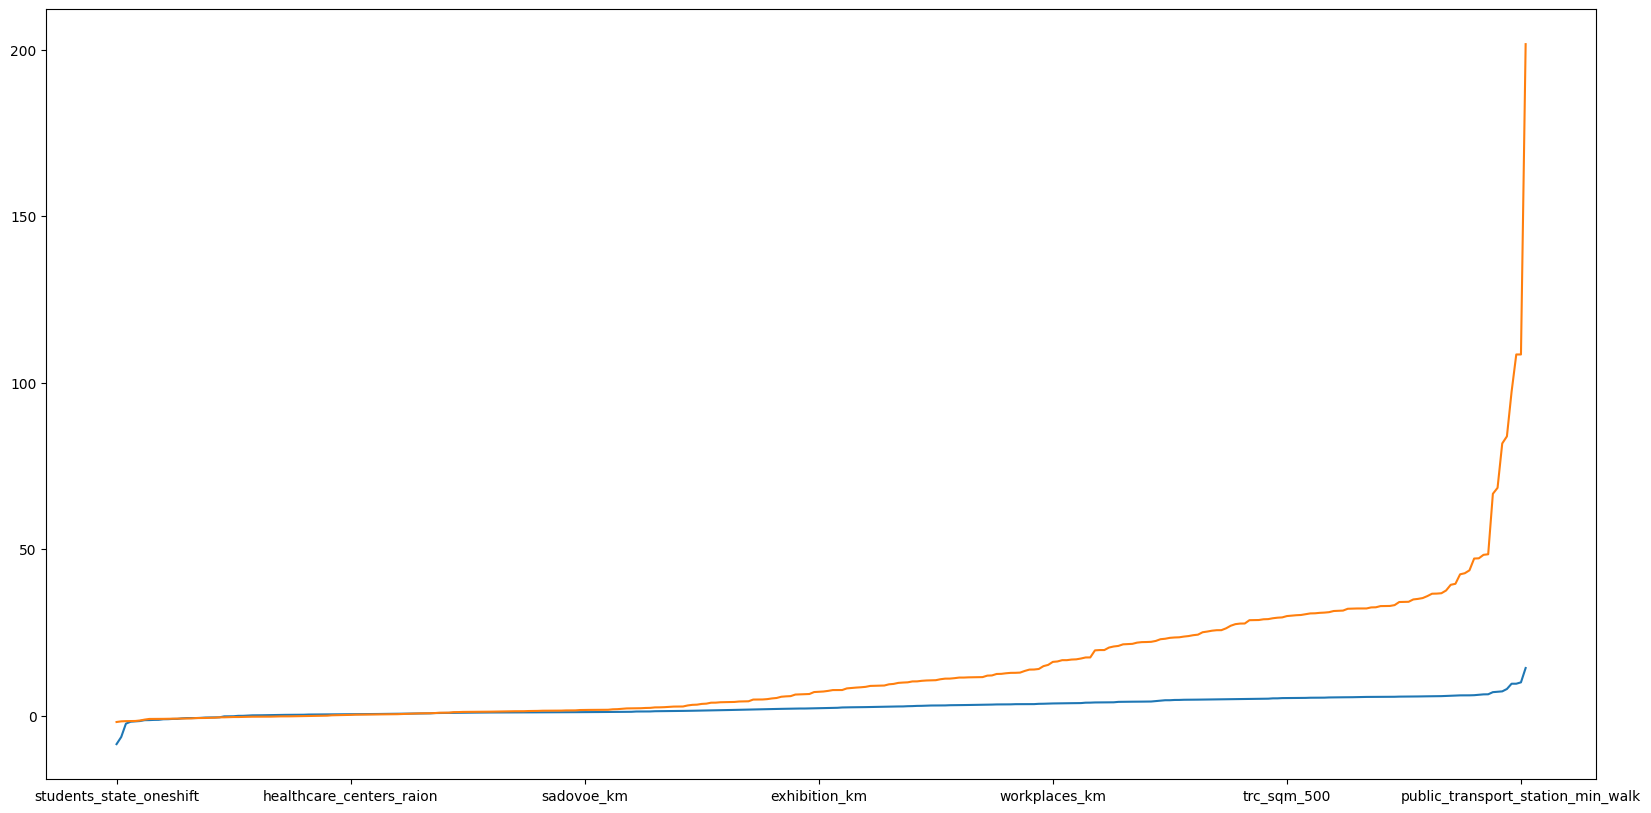

In [283]:
all_skew = pd.Series({'test': 0})
all_kurtosis = pd.Series({'test': 0})
for col in train_no_anomaly.columns:
    all_skew = pd.concat([pd.Series({col: skew(train_no_anomaly[col])}), all_skew])
    all_kurtosis = pd.concat([pd.Series({col: kurtosis(train_no_anomaly[col])}), all_kurtosis])
all_skew = all_skew.drop('test').sort_values()
all_kurtosis = all_kurtosis.drop('test').sort_values()

all_skew.sort_values().plot(figsize=(20, 10))
all_kurtosis.sort_values().plot(figsize=(20, 10))

In [285]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [286]:
X = train_no_anomaly.drop(['price_doc'], axis=1)
y = train_no_anomaly['price_doc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [287]:
forest = RandomForestRegressor()

In [288]:
forest.fit(X_train, y_train)

RandomForestRegressor()

In [292]:
forest.score(X_test, y_test)

0.8100889445480628

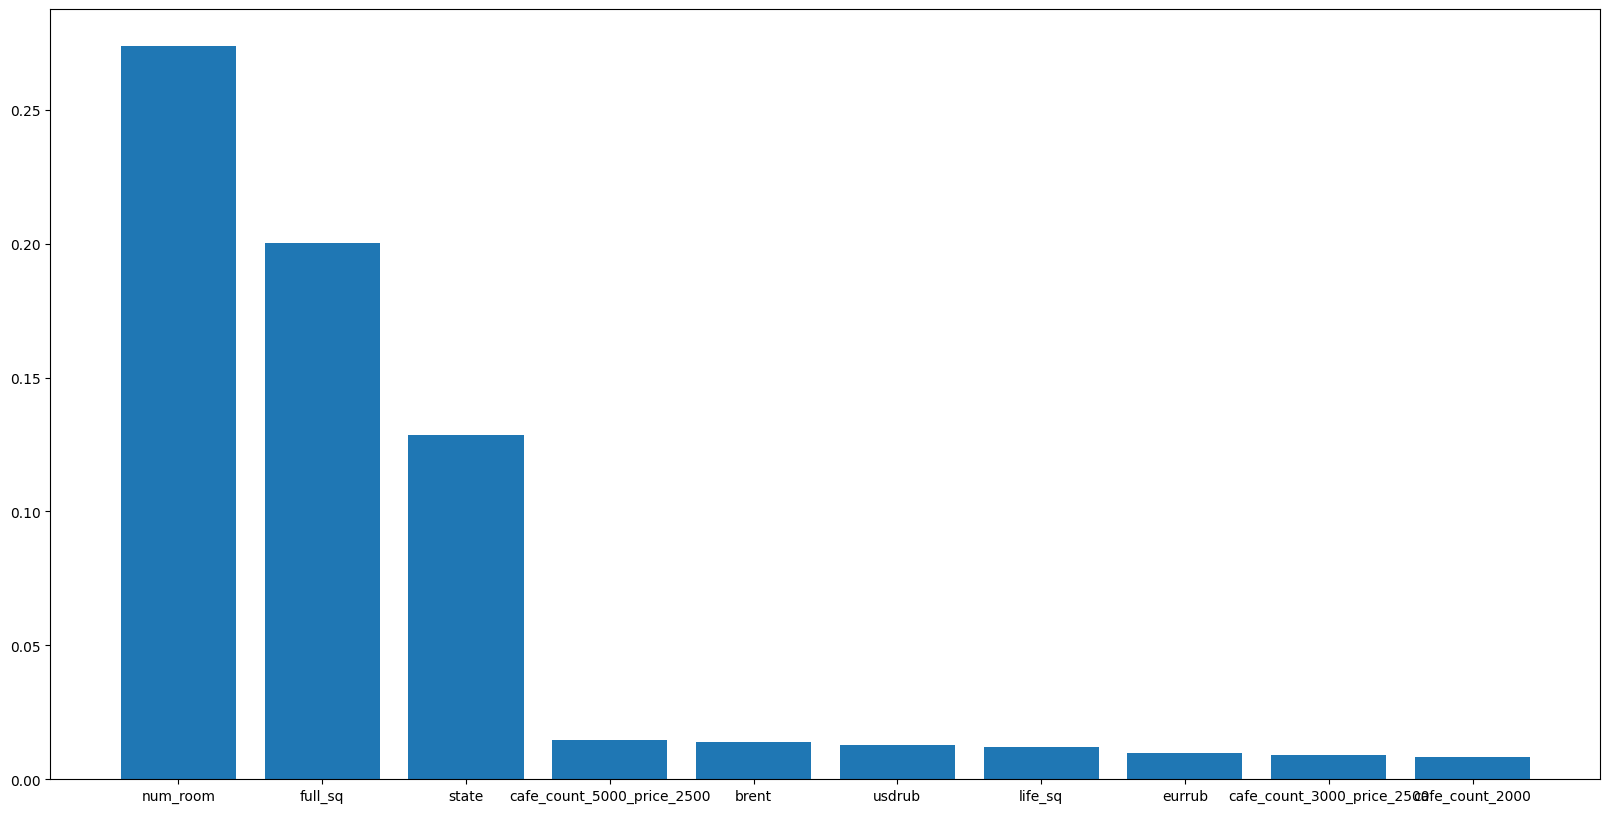

In [317]:
df = pd.DataFrame({'col': X_train.columns, 'imp': forest.feature_importances_}).sort_values('imp', ascending=False)
plt.figure(figsize=(20, 10))
plt.bar(df['col'][:10], df['imp'][:10])
important = df.head(20)
important_1 = important.head(7)

In [318]:
X = train_no_anomaly[important_1['col']]
y = train_no_anomaly['price_doc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [319]:
forest = RandomForestRegressor()

In [320]:
forest.fit(X_train, y_train)

RandomForestRegressor()

In [321]:
forest.score(X_test, y_test)

0.7783207289450931

In [289]:
import joblib

In [347]:
joblib.dump(forest, 'forest_3.joblib')

['forest_3.joblib']

In [ ]:
Подсчитаем среднюю стоимость квадратного метра по годам
Не используем данные без пропусков тк они созданы при помощи регрессии как раз по площади

In [345]:
train = pd.read_csv('train.csv')
macro = pd.read_csv('macro.csv')
train = pd.merge(train, macro, on='timestamp')
usd_end = train.at[train.index[-1], 'usdrub']
for ind in train.index:
    train.at[ind, 'price_doc'] *= (usd_end / train.at[ind, 'usdrub'])
avg_2011, avg_2012, avg_2013, avg_2014, avg_2015 = 0, 0, 0, 0, 0
c_2011, c_2012, c_2013, c_2014, c_2015 = 0, 0, 0, 0, 0
for ind in train.index:
    if train.at[ind, 'timestamp'][:4] == '2011':
        avg_2011 += train.at[ind, 'price_doc'] / train.at[ind, 'full_sq']
        c_2011 += 1
    elif train.at[ind, 'timestamp'][:4] == '2012':
        avg_2012 += train.at[ind, 'price_doc'] / train.at[ind, 'full_sq']
        c_2012 += 1
    elif train.at[ind, 'timestamp'][:4] == '2013':
        avg_2013 += train.at[ind, 'price_doc'] / train.at[ind, 'full_sq']
        c_2013 += 1
    elif train.at[ind, 'timestamp'][:4] == '2014' and train.at[ind, 'full_sq'] != 0:
        avg_2014 += train.at[ind, 'price_doc'] / train.at[ind, 'full_sq']
        c_2014 += 1
    elif train.at[ind, 'timestamp'][:4] == '2015':
        avg_2015 += train.at[ind, 'price_doc'] / train.at[ind, 'full_sq']
        c_2015 += 1
print(avg_2011 / c_2011, avg_2012 / c_2012, avg_2013 / c_2013, avg_2014 / c_2014, avg_2015 / c_2015)

C:\Users\37ham\AppData\Local\Temp\ipykernel_13132\2192773722.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11146540.40020962' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.at[ind, 'price_doc'] *= (usd_end / train.at[ind, 'usdrub'])


218346.21654671922 219372.8779547533 219795.54862257375 217920.57327095143 137801.00519776545


In [346]:
train = pd.read_csv('train.csv')
macro = pd.read_csv('macro.csv')
train = pd.merge(train, macro, on='timestamp')
#usd_end = train.at[train.index[-1], 'usdrub']
#for ind in train.index:
    #train.at[ind, 'price_doc'] *= (usd_end / train.at[ind, 'usdrub'])
avg_2011, avg_2012, avg_2013, avg_2014, avg_2015 = 0, 0, 0, 0, 0
c_2011, c_2012, c_2013, c_2014, c_2015 = 0, 0, 0, 0, 0
for ind in train.index:
    if train.at[ind, 'timestamp'][:4] == '2011':
        avg_2011 += train.at[ind, 'price_doc'] / train.at[ind, 'full_sq']
        c_2011 += 1
    elif train.at[ind, 'timestamp'][:4] == '2012':
        avg_2012 += train.at[ind, 'price_doc'] / train.at[ind, 'full_sq']
        c_2012 += 1
    elif train.at[ind, 'timestamp'][:4] == '2013':
        avg_2013 += train.at[ind, 'price_doc'] / train.at[ind, 'full_sq']
        c_2013 += 1
    elif train.at[ind, 'timestamp'][:4] == '2014' and train.at[ind, 'full_sq'] != 0:
        avg_2014 += train.at[ind, 'price_doc'] / train.at[ind, 'full_sq']
        c_2014 += 1
    elif train.at[ind, 'timestamp'][:4] == '2015':
        avg_2015 += train.at[ind, 'price_doc'] / train.at[ind, 'full_sq']
        c_2015 += 1
print(avg_2011 / c_2011, avg_2012 / c_2012, avg_2013 / c_2013, avg_2014 / c_2014, avg_2015 / c_2015)

123153.7671790046 123132.14524345857 127558.40337681002 154298.1869423413 142174.21017616
